In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Simulate loading the dataset (replace with actual dataset if provided)
# Assuming structure from PDF: 8790 rows, 10 columns
data = pd.read_csv('/content/netflix1-dataset.csv')
# Display basic info
print("Dataset Info:")
print(data.info())
print("\nFirst few rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB
None

First few rows:
  show_id     type                             title         director  \
0      s1    Movie              Dick Johnson Is Dead  Kirsten Johnson   
1      s3  TV Show                         Ganglands  Julien Leclercq   
2      s6  TV Show                     Midnight Mass    Mike Flanagan   
3     s14

In [ ]:
# Check for duplicates
print("Number of duplicates:", data.duplicated().sum())
data.drop_duplicates(inplace=True)

# Convert 'date_added' to datetime
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

# Extract year, month, day from 'date_added'
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month
data['day_added'] = data['date_added'].dt.day

# Split 'listed_in' into genres list
data['genres'] = data['listed_in'].apply(lambda x: x.split(', '))

# Drop unneeded columns (e.g., 'show_id' is not useful for analysis)
data.drop(columns=['show_id'], inplace=True, errors='ignore')

# Check data types
print("\nData types after cleaning:")
print(data.dtypes)

Number of duplicates: 0

Data types after cleaning:
type                    object
title                   object
director                object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
year_added               int32
month_added              int32
day_added                int32
genres                  object
dtype: object


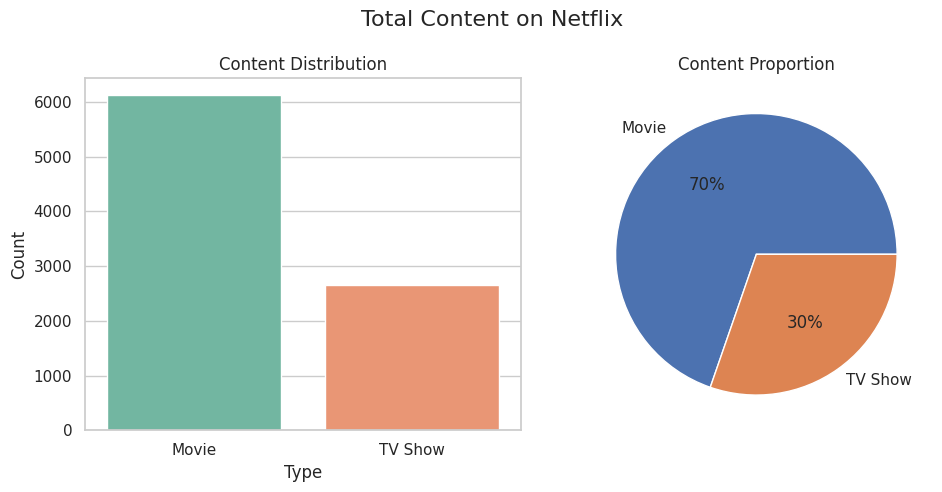

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame with the Netflix dataset
freq = data['type'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot
sns.countplot(data=data, x='type', ax=axes[0], palette='Set2')
axes[0].set_title('Content Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Count')

# Pie chart
axes[1].pie(freq, labels=['Movie', 'TV Show'], autopct='%.0f%%')
axes[1].set_title('Content Proportion')

plt.suptitle('Total Content on Netflix', fontsize=16)
plt.tight_layout()
plt.show()

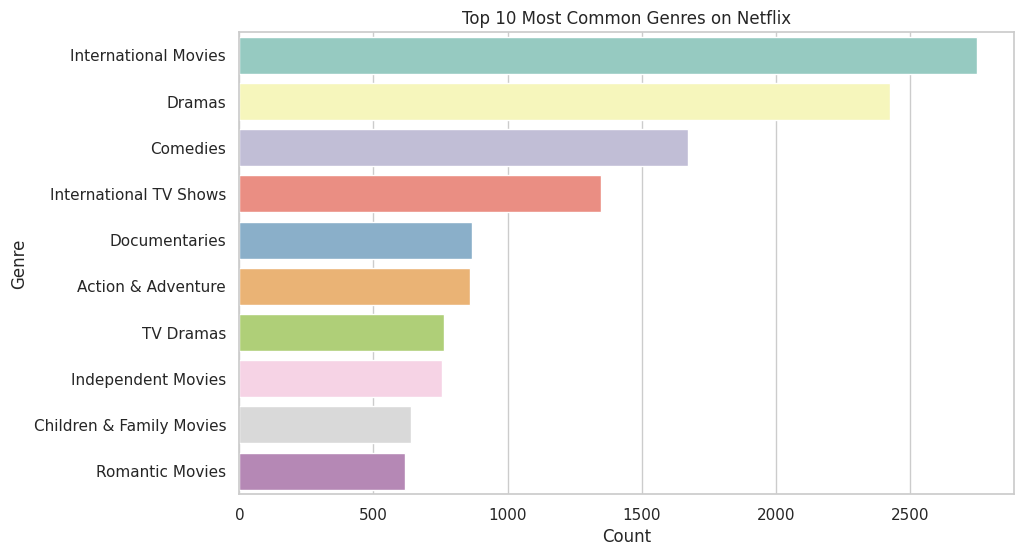

In [ ]:
# Flatten genres list and count
all_genres = sum(data['genres'], [])
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Set3')
plt.title('Top 10 Most Common Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

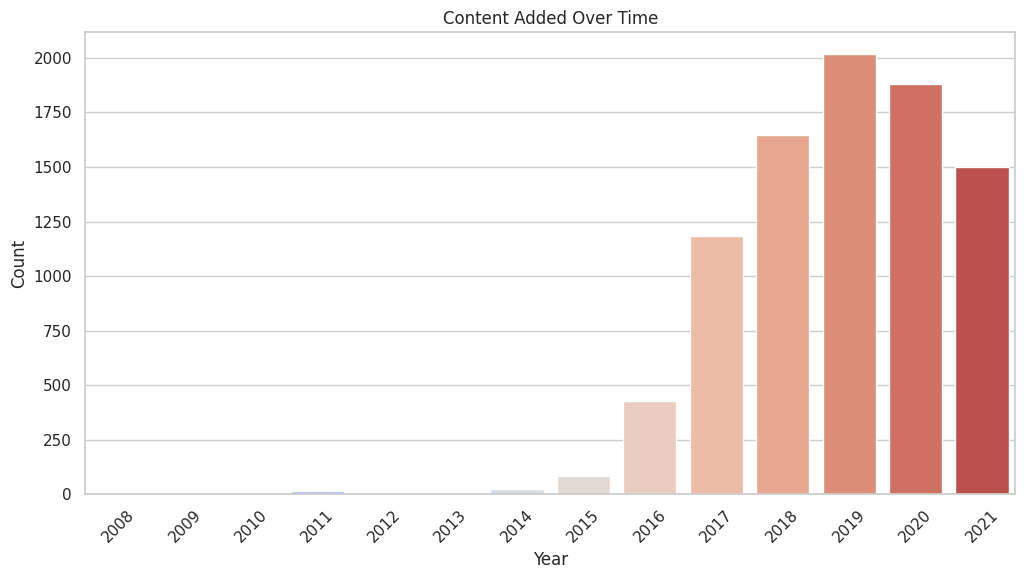

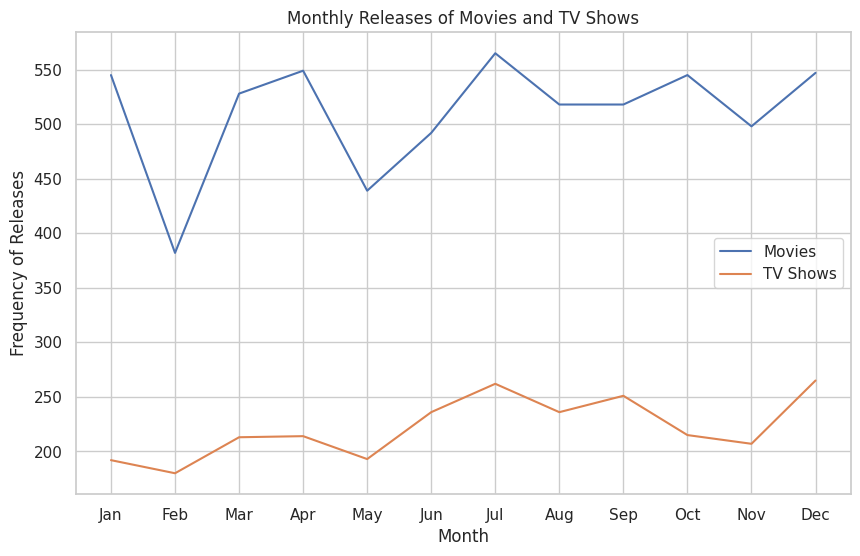

In [ ]:
# Yearly content added
plt.figure(figsize=(12, 6))
sns.countplot(x='year_added', data=data, palette='coolwarm')
plt.title('Content Added Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Monthly releases by type
monthly_movie_release = data[data['type'] == 'Movie']['month_added'].value_counts().sort_index()
monthly_series_release = data[data['type'] == 'TV Show']['month_added'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_movie_release.index, monthly_movie_release.values, label='Movies')
plt.plot(monthly_series_release.index, monthly_series_release.values, label='TV Shows')
plt.xlabel('Month')
plt.ylabel('Frequency of Releases')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.title('Monthly Releases of Movies and TV Shows')
plt.show()

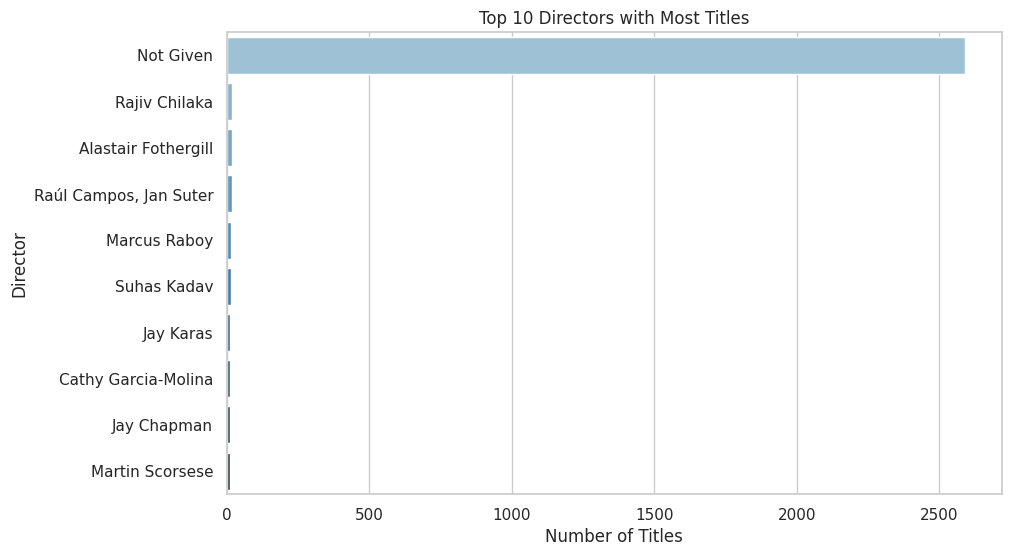

In [ ]:
# Top 10 directors
top_directors = data['director'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='Blues_d')
plt.title('Top 10 Directors with Most Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()

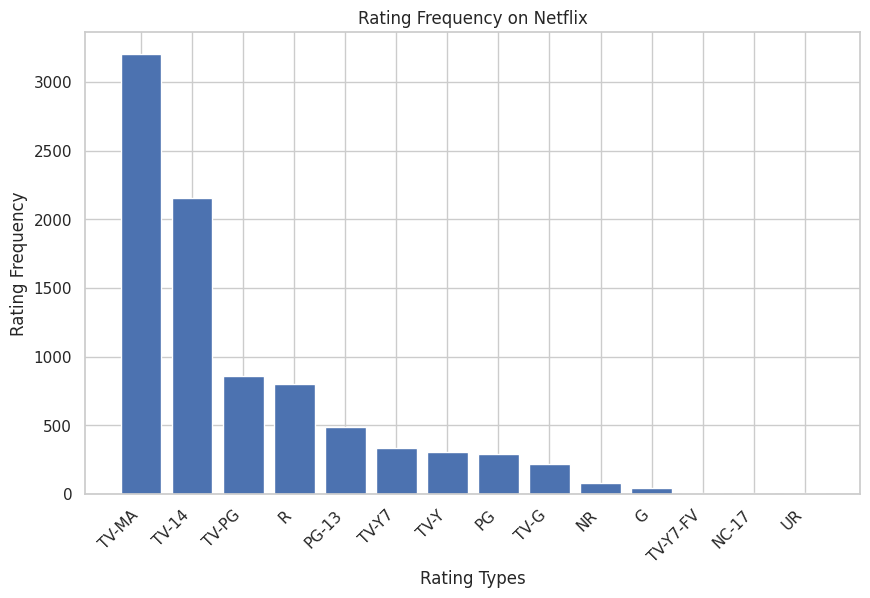

In [ ]:
# Rating frequency
ratings = data['rating'].value_counts().reset_index().sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(ratings['rating'], ratings['count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Rating Types')
plt.ylabel('Rating Frequency')
plt.title('Rating Frequency on Netflix')
plt.show()

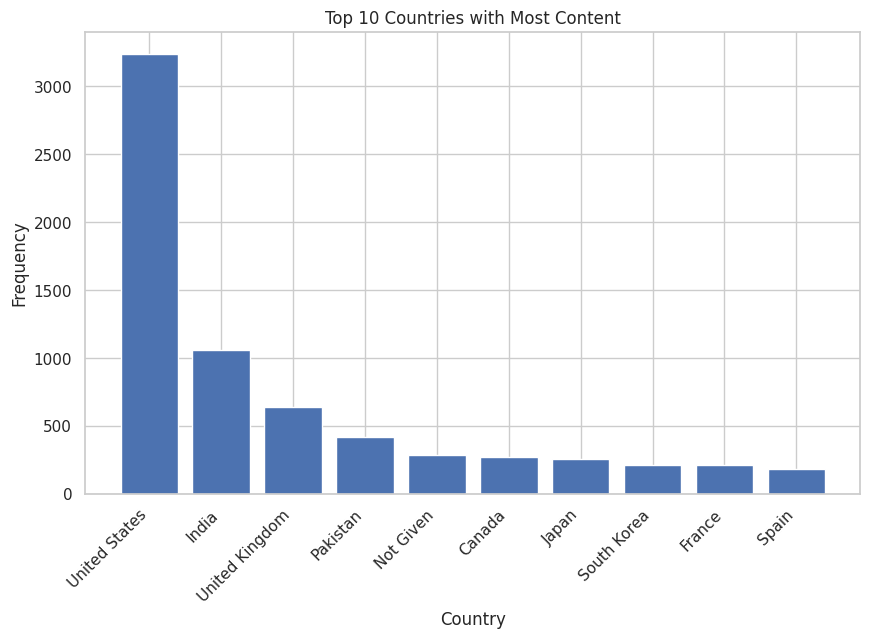

In [ ]:
# Top 10 countries
top_countries = data['country'].value_counts().reset_index().sort_values(by='count', ascending=False)[:10]
plt.figure(figsize=(10, 6))
plt.bar(top_countries['country'], top_countries['count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 10 Countries with Most Content')
plt.show()

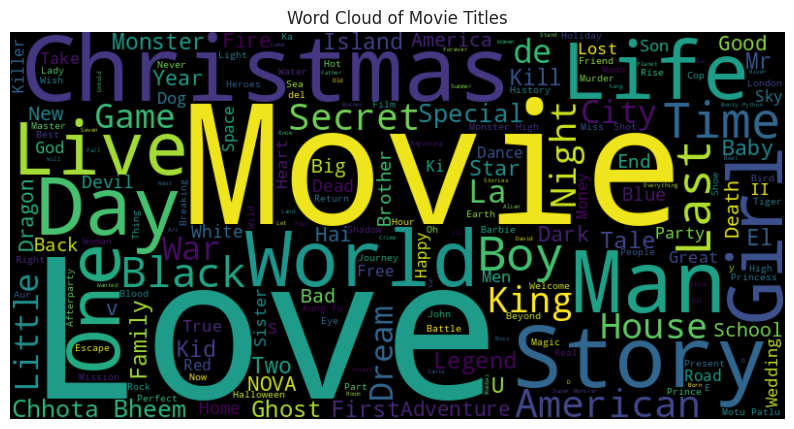

In [ ]:
# Word cloud for movie titles
movie_titles = data[data['type'] == 'Movie']['title']
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(movie_titles))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

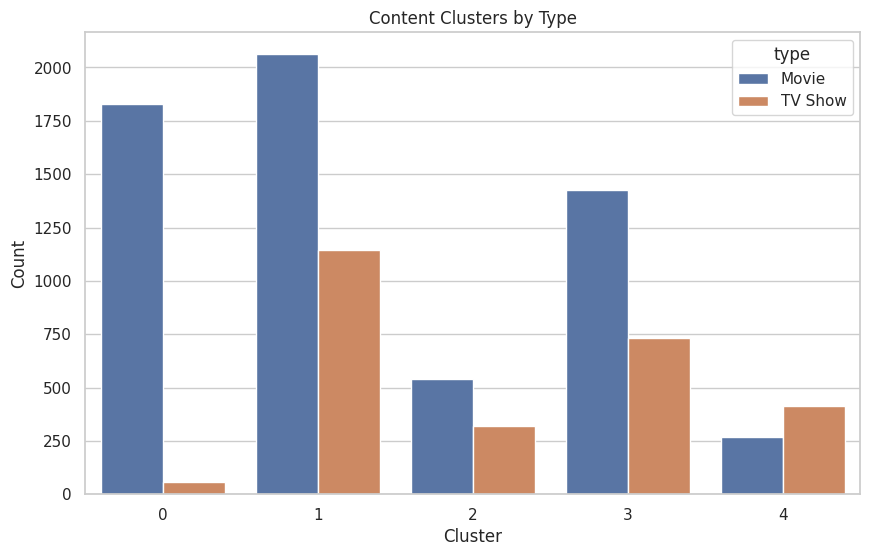

In [ ]:
# Encode genres and ratings
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
genre_tfidf = tfidf.fit_transform(data['genres']).toarray()
rating_encoded = pd.get_dummies(data['rating']).values
features = np.hstack([genre_tfidf, rating_encoded])

# Apply K-means
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='type', data=data)
plt.title('Content Clusters by Type')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

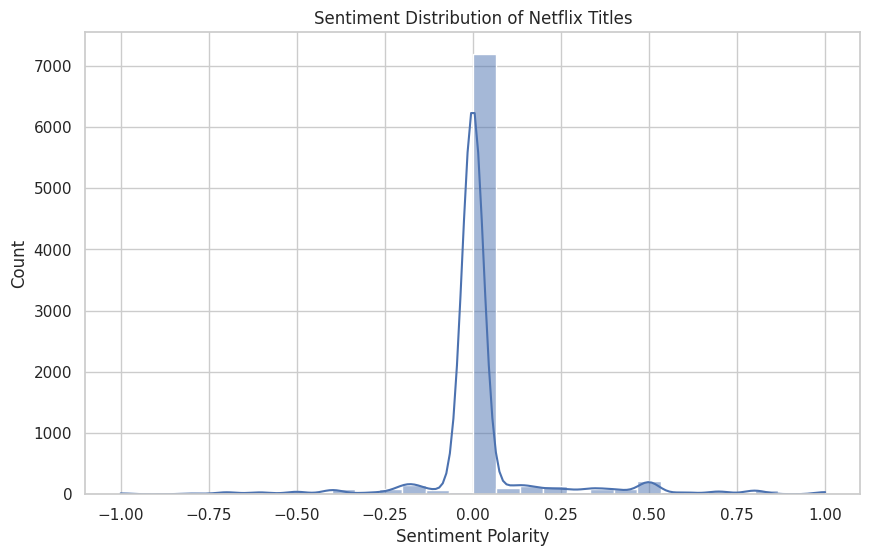

In [ ]:
# Sentiment analysis of titles
data['title_sentiment'] = data['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure(figsize=(10, 6))
sns.histplot(data['title_sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution of Netflix Titles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Count')
plt.show()

In [ ]:
# Compute cosine similarity on genres
cosine_sim = cosine_similarity(genre_tfidf)

# Function to recommend titles
def recommend_titles(title, data, cosine_sim, top_n=5):
    idx = data[data['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    title_indices = [i[0] for i in sim_scores]
    return data['title'].iloc[title_indices]

# Example recommendation
print("Recommendations for 'Midnight Mass':")
print(recommend_titles('Midnight Mass', data, cosine_sim))

Recommendations for 'Midnight Mass':
6619       Brand New Cherry Flavor
7046     The Haunting of Bly Manor
7076                       Ratched
7910    The Haunting of Hill House
7962                 The Originals
Name: title, dtype: object


In [ ]:
# Interactive plot of yearly releases
yearly_releases = data.groupby(['year_added', 'type']).size().reset_index(name='count')
fig = px.line(yearly_releases, x='year_added', y='count', color='type',
              title='Yearly Releases of Movies and TV Shows')
fig.update_layout(xaxis_title='Year', yaxis_title='Frequency')
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import networkx as nx

# Assume dataset is loaded (replace with actual dataset if provided)
# data = pd.read_csv('/kaggle/input/netflix-data-cleaning-analysis-and-visualization/netflix1.csv')
# For demonstration, assume data is already cleaned as per previous response

# Feature: Convert duration to numeric
def parse_duration(duration):
    if 'min' in duration:
        return int(duration.split()[0])
    elif 'Season' in duration:
        return int(duration.split()[0]) * 10  # Assume 10 episodes per season
    return np.nan

data['duration_numeric'] = data['duration'].apply(parse_duration)

# Feature: Number of genres
data['genre_count'] = data['genres'].apply(len)

# Feature: Age of content
data['content_age'] = data['year_added'] - data['release_year']

# Feature: Region from country
country_to_region = {
    'United States': 'North America', 'India': 'Asia', 'United Kingdom': 'Europe',
    'Pakistan': 'Asia', 'Brazil': 'South America', 'Not Given': 'Unknown',
    # Add more mappings as needed
}
data['region'] = data['country'].map(country_to_region).fillna('Other')

# Verify new features
print("New Features:")
print(data[['duration_numeric', 'genre_count', 'content_age', 'region']].head())

New Features:
   duration_numeric  genre_count  content_age         region
0                90            1            1  North America
1                10            3            0          Other
2                10            3            0  North America
3                91            2            0  South America
4               125            3           28  North America


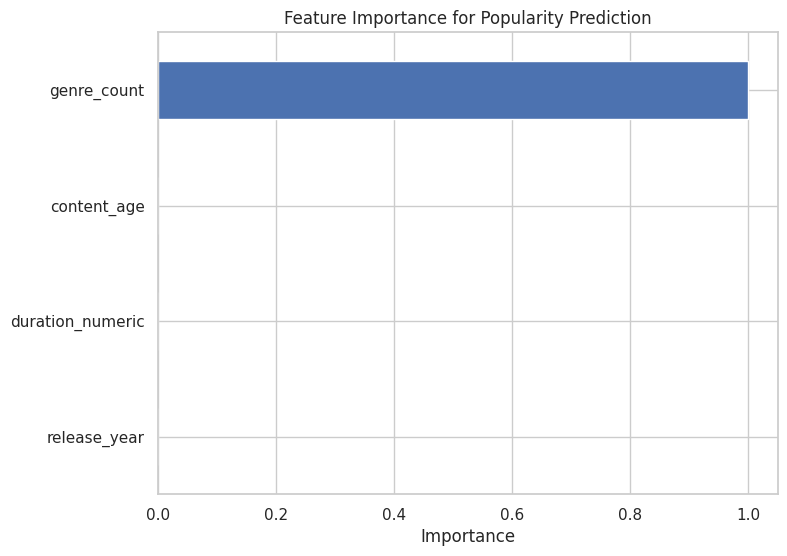

In [ ]:
# Prepare features for ML
features = ['release_year', 'duration_numeric', 'genre_count', 'content_age']
X = data[features].fillna(0)
y = data['genre_count']  # Proxy for popularity

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature importance
importance = pd.Series(rf.feature_importances_, index=features)
plt.figure(figsize=(8, 6))
importance.sort_values().plot(kind='barh')
plt.title('Feature Importance for Popularity Prediction')
plt.xlabel('Importance')
plt.show()

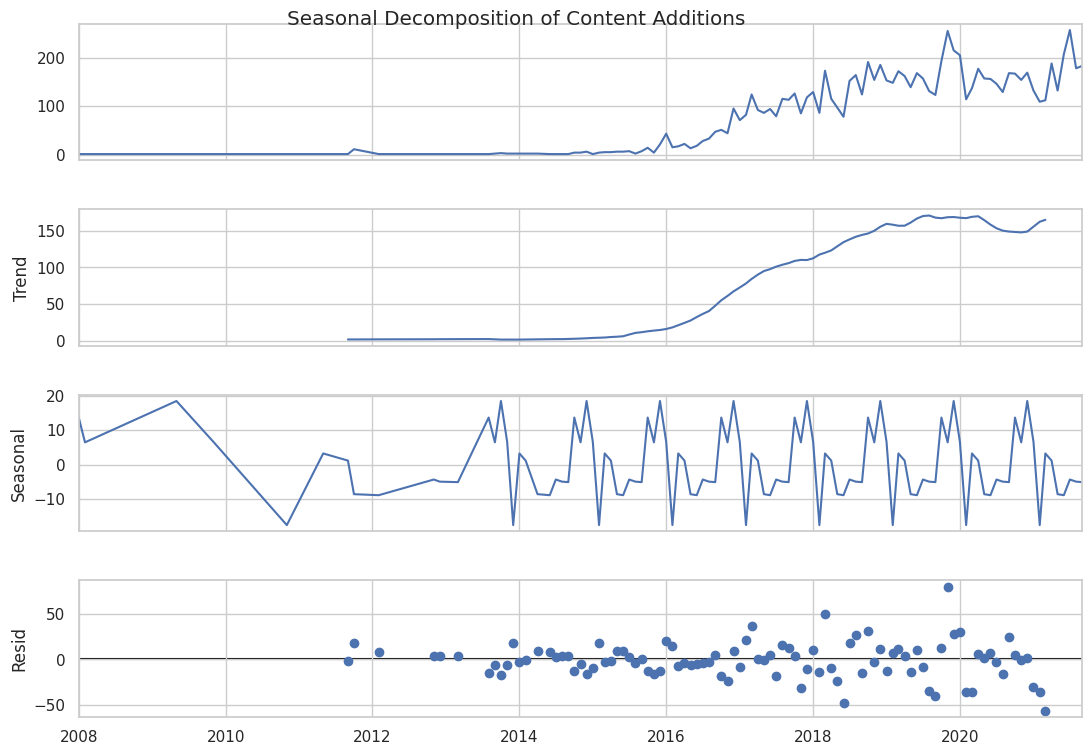

In [ ]:
# Time-series of content additions
data['date_added'] = pd.to_datetime(data['date_added'])
monthly_counts = data.groupby(data['date_added'].dt.to_period('M')).size()
ts = pd.Series(monthly_counts.values, index=monthly_counts.index.to_timestamp())

# Decompose
decomposition = seasonal_decompose(ts, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Content Additions')
plt.show()

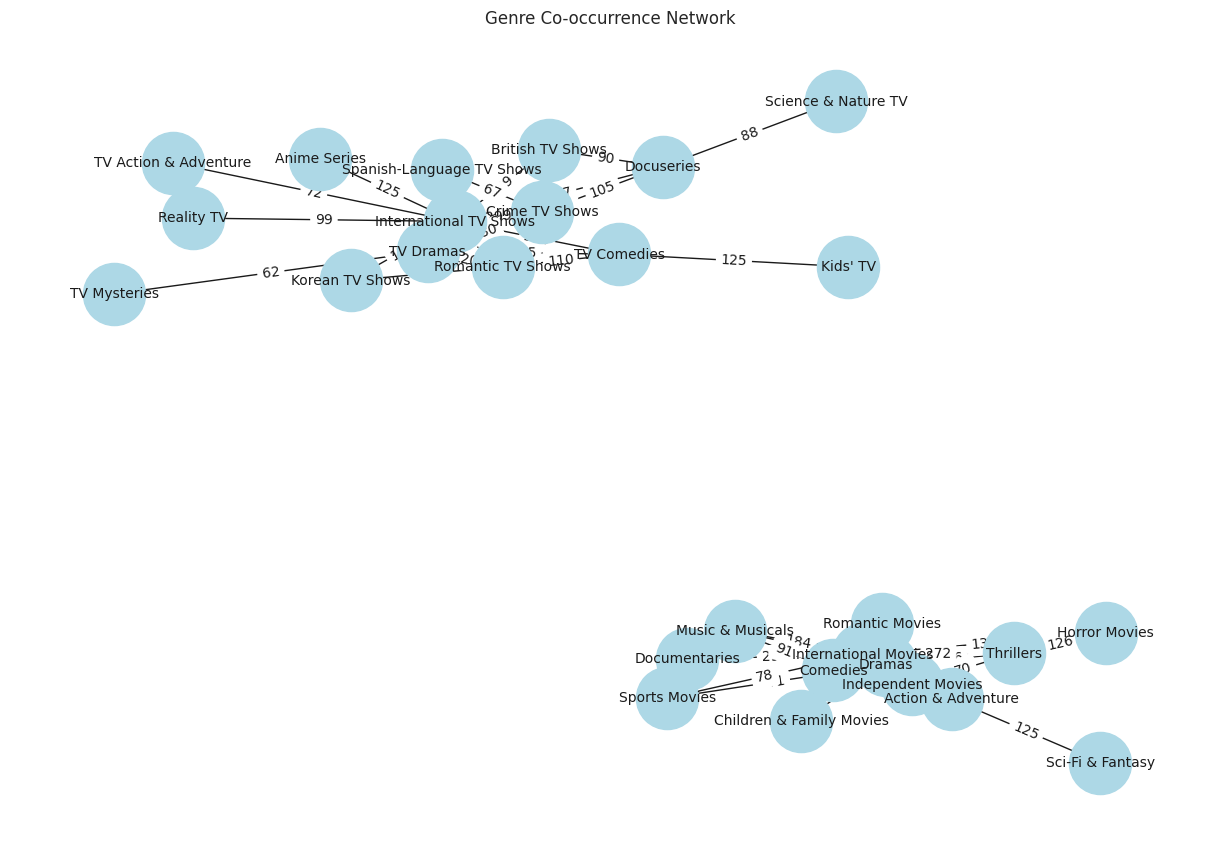

In [ ]:
# Create co-occurrence matrix
from itertools import combinations
genre_pairs = [list(combinations(genres, 2)) for genres in data['genres']]
flat_pairs = [pair for pairs in genre_pairs for pair in pairs]
co_occurrence = pd.DataFrame(flat_pairs, columns=['genre1', 'genre2']).value_counts().reset_index(name='count')

# Build network
G = nx.Graph()
for _, row in co_occurrence.head(50).iterrows():  # Top 50 pairs
    G.add_edge(row['genre1'], row['genre2'], weight=row['count'])

# Visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.title('Genre Co-occurrence Network')
plt.show()

In [ ]:
# Interactive genre-region analysis
genre_region = data.explode('genres').groupby(['genres', 'region']).size().reset_index(name='count')
fig = px.bar(genre_region, x='genres', y='count', color='region', barmode='stack',
             title='Genre Distribution by Region')
fig.update_layout(xaxis_title='Genre', yaxis_title='Count', xaxis_tickangle=45)
fig.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import uuid

# Load dataset
data = pd.read_csv('netflix1-dataset.csv')

# Clean and preprocess
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

# Feature: Numeric duration
def parse_duration(duration):
    if isinstance(duration, str):
        if 'min' in duration:
            return int(duration.split()[0])
        elif 'Season' in duration:
            return int(duration.split()[0])
    return np.nan

data['duration_numeric'] = data['duration'].apply(parse_duration)

# Feature: Genre count
data['genres'] = data['listed_in'].str.split(', ')
data['genre_count'] = data['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Feature: Year and month added
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month

# Feature: Region
country_to_region = {
    'United States': 'North America', 'India': 'Asia', 'United Kingdom': 'Europe',
    'Pakistan': 'Asia', 'Brazil': 'South America', 'France': 'Europe', 'Germany': 'Europe',
    'Japan': 'Asia', 'South Africa': 'Africa', 'Nigeria': 'Africa', 'China': 'Asia',
    'Australia': 'Oceania', 'Canada': 'North America', 'Not Given': 'Unknown'
}
data['region'] = data['country'].map(country_to_region).fillna('Other')

# Handle missing values
data['duration_numeric'].fillna(data['duration_numeric'].median(), inplace=True)
data['year_added'].fillna(data['year_added'].median(), inplace=True)
data['month_added'].fillna(data['month_added'].median(), inplace=True)

# Encode categorical variables for ML
le_type = LabelEncoder()
data['type_encoded'] = le_type.fit_transform(data['type'])
le_rating = LabelEncoder()
data['rating_encoded'] = le_rating.fit_transform(data['rating'].fillna('Unknown'))

# Save preprocessed data
data.to_csv('netflix_preprocessed.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

# Assuming data is preprocessed as per previous response
# Load dataset (replace with your path if needed)
data = pd.read_csv('netflix1-dataset.csv')

# Preprocessing (recap for clarity)
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

# Feature: Numeric duration
def parse_duration(duration):
    if isinstance(duration, str):
        if 'min' in duration:
            return int(duration.split()[0])
        elif 'Season' in duration:
            return int(duration.split()[0])
    return np.nan

data['duration_numeric'] = data['duration'].apply(parse_duration)

# Feature: Genre count
data['genres'] = data['listed_in'].str.split(', ')
data['genre_count'] = data['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Feature: Year added
data['year_added'] = data['date_added'].dt.year

# Handle missing values
data['duration_numeric'].fillna(data['duration_numeric'].median(), inplace=True)
data['year_added'].fillna(data['year_added'].median(), inplace=True)

# Encode categorical variables
le_type = LabelEncoder()
data['type_encoded'] = le_type.fit_transform(data['type'])
le_rating = LabelEncoder()
data['rating_encoded'] = le_rating.fit_transform(data['rating'].fillna('Unknown'))

# Prepare features
features = ['release_year', 'duration_numeric', 'genre_count', 'year_added', 'rating_encoded']
X = data[features]
y = data['type_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_type.classes_))

# Feature importance
importance = pd.Series(rf.feature_importances_, index=features)
fig = px.bar(x=importance.values, y=importance.index, orientation='h',
             title='Feature Importance for Content Type Prediction',
             labels={'x': 'Importance', 'y': 'Feature'},
             color=importance.values, color_continuous_scale='Viridis')
fig.update_layout(template='plotly_dark', font=dict(size=12))
fig.write_html('feature_importance.html')  # Corrected method

Classification Report:
              precision    recall  f1-score   support

       Movie       1.00      1.00      1.00      1238
     TV Show       0.99      1.00      0.99       520

    accuracy                           1.00      1758
   macro avg       0.99      1.00      1.00      1758
weighted avg       1.00      1.00      1.00      1758



In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load dataset (replace with your path if needed)
data = pd.read_csv('netflix1-dataset.csv')

# Preprocessing
# Convert date_added to datetime, handling errors
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

# Extract year and month, ensuring integer types
data['year_added'] = data['date_added'].dt.year
data['month_added'] = data['date_added'].dt.month

# Handle missing values with median, convert to integer
data['year_added'] = data['year_added'].fillna(data['year_added'].median()).astype(int)
data['month_added'] = data['month_added'].fillna(data['month_added'].median()).astype(int)

# Split genres
data['genres'] = data['listed_in'].str.split(', ')

# Map countries to regions
country_to_region = {
    'United States': 'North America', 'India': 'Asia', 'United Kingdom': 'Europe',
    'Pakistan': 'Asia', 'Brazil': 'South America', 'France': 'Europe', 'Germany': 'Europe',
    'Japan': 'Asia', 'South Africa': 'Africa', 'Nigeria': 'Africa', 'China': 'Asia',
    'Australia': 'Oceania', 'Canada': 'North America', 'Not Given': 'Unknown'
}
data['region'] = data['country'].map(country_to_region).fillna('Other')

# Bar chart: Content type by genre
genre_counts = data.explode('genres').groupby(['type', 'genres']).size().reset_index(name='count')
top_genres = genre_counts.groupby('genres')['count'].sum().nlargest(10).index
genre_counts = genre_counts[genre_counts['genres'].isin(top_genres)]
fig1 = px.bar(genre_counts, x='genres', y='count', color='type', barmode='group',
              title='Content Distribution by Type and Top Genres',
              labels={'genres': 'Genre', 'count': 'Count'},
              color_discrete_sequence=['#1f77b4', '#ff7f0e'])
fig1.update_layout(template='plotly_dark', font=dict(size=12))
fig1.write_html('genre_distribution.html')

# Time-series: Content additions
monthly_counts = data.groupby(['year_added', 'month_added']).size().reset_index(name='count')
# Ensure year_added and month_added are integers
monthly_counts['year_added'] = monthly_counts['year_added'].astype(int)
monthly_counts['month_added'] = monthly_counts['month_added'].astype(int)
# Create date column using string formatting to avoid pd.to_datetime issues
monthly_counts['date'] = pd.to_datetime(
    monthly_counts['year_added'].astype(str) + '-' +
    monthly_counts['month_added'].astype(str).str.zfill(2) + '-01'
)
fig2 = px.line(monthly_counts, x='date', y='count',
               title='Monthly Content Additions',
               labels={'date': 'Date', 'count': 'Number of Additions'},
               color_discrete_sequence=['#2ca02c'])
fig2.update_layout(template='plotly_dark', font=dict(size=12))
fig2.write_html('content_additions.html')

# Stacked bar: Genre by region
genre_region = data.explode('genres').groupby(['genres', 'region']).size().reset_index(name='count')
top_genres = genre_region.groupby('genres')['count'].sum().nlargest(10).index
genre_region = genre_region[genre_region['genres'].isin(top_genres)]
fig3 = px.bar(genre_region, x='genres', y='count', color='region', barmode='stack',
              title='Genre Distribution by Region',
              labels={'genres': 'Genre', 'count': 'Count'},
              color_discrete_sequence=px.colors.qualitative.Plotly)
fig3.update_layout(template='plotly_dark', font=dict(size=12))
fig3.write_html('genre_region.html')